In [4]:
import os
import glob
import pickle

import pandas as pd
import numpy as np
from ast import literal_eval

from gensim import corpora, models
from gensim.models.callbacks import PerplexityMetric
from gensim.models.coherencemodel import CoherenceModel

# Косинусная метрика для рассчёта расстояний 
from scipy.spatial.distance import cosine

# Визуализация
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import seaborn as sns
from wordcloud import WordCloud
import pyLDAvis.gensim

import warnings
warnings.filterwarnings('ignore')

In [5]:
path = r'C:\Users\savintseva\_University\parsing\youtube comments\usa\comments_usa'
path_for_reduced = r'C:\Users\savintseva\_University\parsing\youtube comments\usa\comments_usa\reduced'

In [6]:
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0, sep='\t')
    li.append(df)

data = pd.concat(li, axis=0, ignore_index=True)
data.head()

Unnamed: 0                          video_name                  comment_id  \
0           0  Kids honor moms on the front lines  UgyTbidkqrIqmQz9xl54AaABAg   
1           1  Kids honor moms on the front lines  UgytHMgiwHjdfcl7oA54AaABAg   
2           2  Kids honor moms on the front lines  UgwP9-dtMoqNPfYNQWF4AaABAg   
3           3  Kids honor moms on the front lines  UgzD258dg0cQUhkNoqB4AaABAg   
4           4  Kids honor moms on the front lines  UgxQfCvqLD-aOHRDUAF4AaABAg   

           author                                               text  \
0   Dennis Menace                                   what about dads?   
1     Sleepy Pink  Where’s mommies with other jobs ? Happy Mother...   
2              Tc  Front lines of what ? That's what they went to...   
3  Lupus Iudicium                                         Frontlies*   
4        NewDrew2                               I love propaganda 😫💜   

                   date  likes  \
0  2020-05-09T11:15:30Z      0   
1  2020-05-09T10:07:55Z      1   
2  2020-05-09T05:23:16Z      3   
3  2020-05-09T04:24:03Z      1   
4  2020-05-09T04:06:28Z      0   

                                          clean_text country   channel  \
0                                    what about dads     usa  abc_news   
1  wheres mommies with other jobs  happy mothers ...     usa  abc_news   
2  front lines of what  thats what they went to s...     usa  abc_news   
3                                          frontlies     usa  abc_news   
4                                 i love propaganda      usa  abc_news   

                                               lemma  \
0                           ['what', 'about', 'dad']   
1  ['where', 'mommies', 'with', 'other', 'job', '...   
2  ['front', 'line', 'of', 'what', '', 'thats', '...   
3                                      ['frontlies']   
4                    ['i', 'love', 'propaganda', '']   

                                        pure_comment  length  
0                                            ['dad']       1  
1  ['mommies', 'job', '', 'happy', 'mother', 'day...       8  
2                       ['', 'school', 'pay', 'job']       4  
3                                      ['frontlies']       1  
4                         ['love', 'propaganda', '']       3

In [7]:
del data['Unnamed: 0']

In [8]:
reduced_data = data[data['length']>1]
print('data shape', data.shape)
print('reduced data shape', reduced_data.shape)

os.chdir(path_for_reduced)
reduced_data.to_csv('reduced_comments.csv')

data = reduced_data #Строим модель на reduced data

data shape (6463610, 12)
reduced data shape (6034852, 12)


In [9]:
os.chdir(path)

In [10]:
def make_bigrams(text):
    return [bigram_mod[doc] for doc in text]

texts = data.pure_comment.apply(literal_eval)
bigram = models.Phrases(texts, min_count=3, threshold=5)
bigram_mod = models.phrases.Phraser(bigram)

texts = make_bigrams(texts)

In [11]:
dictionary = corpora.Dictionary(texts)
print('Размер словаря до фильтрации: {}'.format(len(dictionary)))
dictionary.filter_extremes(no_below=3, no_above=0.4, keep_n=3*10**6)
print('Размер словаря после фильтрации: {}'.format(len(dictionary)))

with open(r'C:\Users\savintseva\_University\parsing\USA_LDA\dictionary.pickle', 'wb') as f:
    pickle.dump(dictionary, f)

Размер словаря до фильтрации: 1158766
Размер словаря после фильтрации: 399738


In [12]:
corpus = [dictionary.doc2bow(text) for text in texts]
with open(r'C:\Users\savintseva\_University\parsing\USA_LDA\corpus.pickle', 'wb') as f:
    pickle.dump(corpus, f)

In [13]:
# Обучаем модель
np.random.seed(42)

ldamodel_15 = models.ldamodel.LdaModel(corpus, id2word=dictionary, eval_every=20, num_topics=15, passes=5)
ldamodel_15.save(r'C:\Users\savintseva\_University\parsing\USA_LDA\ldamodel_15.model')

In [14]:
with open(r'C:\Users\savintseva\_University\parsing\USA_LDA\ldamodel_15_state.pickle', 'wb') as f:
    pickle.dump(ldamodel_15.state, f)
print(ldamodel_15.state)

In [18]:
# Сохраняем темы для модели

topics_15 = ldamodel_15.show_topics(num_topics=15, num_words=150, formatted=False)
with open(r'C:\Users\savintseva\_University\parsing\USA_LDA\ldamodel_topics_15.pickle', 'wb') as f:
    pickle.dump(topics_15, f)
    
print(topics_15)

[(0, [('word', 0.031562664), ('conjurer', 0.027160794), ('gonna', 0.021991244), ('guess', 0.020888805), ('trust', 0.018683394), ('action', 0.016204594), ('fox_news', 0.015460844), ('expect', 0.0147041185), ('pass', 0.014191345), ('\ufeff1', 0.012618385), ('claim', 0.012020969), ('16', 0.012015537), ('follow', 0.01165468), ('mention', 0.011396457), ('simply', 0.010911795), ('parent', 0.010817472), ('boy', 0.010035038), ('heart', 0.009869124), ('result', 0.009852745), ('dislike', 0.009081403), ('treat', 0.008928336), ('18', 0.008886254), ('accept', 0.008858571), ('time', 0.008702898), ('12', 0.00867014), ('public', 0.008387503), ('book', 0.008113513), ('total', 0.007837746), ('father', 0.0076505863), ('promise', 0.0074095465), ('form', 0.0072315154), ('benefit', 0.007230942), ('bring', 0.0069841766), ('receive', 0.006800391), ('17', 0.0065262513), ('doubt', 0.006429039), ('hypocrite', 0.0061934255), ('donald', 0.006156205), ('25', 0.006071988), ('community', 0.006060386), ('responsibilit

In [19]:
# Визуализируем распределение тем
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel_15, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
5      0.090099  0.175009       1        1  9.407727
11    -0.227887 -0.049070       2        1  8.788120
12    -0.231652  0.020878       3        1  8.135912
3      0.007561 -0.190361       4        1  7.424572
0      0.077334 -0.186364       5        1  6.786792
8     -0.194984 -0.056668       6        1  6.427954
13     0.143075  0.059127       7        1  6.370269
4      0.117813  0.043903       8        1  6.329311
6     -0.130923  0.090269       9        1  6.202698
9      0.099660  0.209111      10        1  6.030263
2      0.125550 -0.211497      11        1  5.967543
1      0.152239 -0.137692      12        1  5.781590
7     -0.188485  0.042921      13        1  5.643124
14     0.095743  0.106481      14        1  5.420437
10     0.064857  0.083954      15        1  5.283680, topic_info=            Term          Freq         Total Category  logprob  loglift
185        trump  1.468779e+06  1.468779e+06  Default  30.0000  30.0000
38        people  1.279711e+06  1.279711e+06  Default  29.0000  29.0000
1183   president  5.103500e+05  5.103500e+05  Default  28.0000  28.0000
157          lie  3.117860e+05  3.117860e+05  Default  27.0000  27.0000
163      america  3.290180e+05  3.290180e+05  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
761         weak  2.149670e+04  2.149796e+04  Topic15  -4.8309   2.9405
1213  generation  2.037542e+04  2.037668e+04  Topic15  -4.8845   2.9405
1245        true  6.228394e+04  8.483491e+04  Topic15  -3.7671   2.6315
7         school  7.281873e+04  1.119548e+05  Topic15  -3.6109   2.5104
585       person  3.748533e+04  1.267927e+05  Topic15  -4.2749   1.7219

[555 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
256       5  0.999973       12
2826     11  0.999969       15
926       5  0.999982       16
1175      5  0.999922       17
517       5  0.999945       18
...     ...       ...      ...
836      12  0.999963     yall
909      10  0.999951     york
1689     12  0.999959  youtube
764       5  0.270879       ﻿1
764       7  0.729115       ﻿1

[597 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 12, 13, 4, 1, 9, 14, 5, 7, 10, 3, 2, 8, 15, 11])

In [43]:
themes_15 = {
	0: 'общественное мнение',
	1: 'ложь и страх',
	2: 'здравоохранение',
	3: 'коронавирус',
	4: 'бог',
	5: 'трамп и ситуация в стране',
	6: 'человеческие чувства',
	7: 'расизм',
	8: 'законопорядок',
	9: 'деньги и работа',
	10: 'ненависть и обман',
	11: 'повседневная жизнь',
	12: 'америка, патриотизм',
	13: 'выборы',
	14: 'криминал и коррупция'
}

In [70]:
# Строим тематические профили

def topicProfileGenre(model, country, dataset, corpus, typeof=True):
    theme_results = [ ]
    # Количество топиков
    r = model.num_topics
    
    # Выбираем из таблицы те строки, которые соовтетствуют текущему типу (или группе)
    if typeof:
        num = dataset[dataset['country'] == country].index
    else:
        num = dataset[dataset['channel'] == country].index

    # Вектор для тематического профиля жанра
    theme_profile = np.zeros(r)
    err = 0 # Для записи ошибок

    # Пробежимся по всем любителям текущего типа/группы
    for i in num:
        try:
            # вытаскиваем тематический профиль текущего юзера
            cur_user_prof = model.get_document_topics(corpus[i])

            # сортируем по номерам тем
            cur_user_prof = sorted(cur_user_prof, key=lambda w: w[0], reverse=True)      

            ind = [cup[0] for cup in cur_user_prof]     # делаем вектор с номерами тем
            prob = np.array([cup[1] for cup in cur_user_prof]) # делаем вектор с весами  
            theme_profile[ind] += prob        # Увеличиваем соответствующие веса
        except:
            err += 1 # Если возникла ошибка, значит профиль битый 

    # Нормируем к единице
    #print('Доля битых профилей для {}:'.format(music_style), err/len(num))
    theme_profile = theme_profile / np.sum(theme_profile)
    theme_profile = list(zip(range(30),theme_profile))
    return theme_profile

def profilePlot(theme_profile, country, themes=themes_15):
    """
    Строит тематическией профиль для каждого жанра
    theme_profile:
        тематический профиль, dict
    news_type: 
        Тип новостей
    themes dict:
        названия тем
    """
    
    theme_profile = theme_profile[country]
    sorted_prof = sorted(theme_profile, key=lambda w: w[1], reverse=True)   
    
    # рисуем картинку
    sns.set(font_scale=2)
    plt.subplots(figsize=(20, 40))
    
    prof = np.array([pr[1] for pr in sorted_prof]).reshape(1,-1)
    them = [themes[pr[0]] for pr in sorted_prof]
    
    ax = plt.axes()    
    sns.heatmap(prof, ax = ax, square=True, annot=True, fmt=".2f", linewidths=0.1, 
                 cmap="YlGnBu", cbar=False, yticklabels='', xticklabels=them )
    ax.set_title('Тематический профиль для {}: \n'.format(country))
    plt.show()

In [45]:
channel_themes = { }
for channel in tqdm_notebook(reduced_data.channel.unique()):
    
    # Выделяем темы для текущего жанра
    theme = topicProfileGenre(ldamodel_15, channel, reduced_data, corpus, typeof=False)
    
    # Записываем их в словарик:
    channel_themes[channel] = theme

In [56]:
reduced_data = pd.read_csv('C:/Users/savintseva/_University/parsing/youtube comments/usa/comments_usa/reduced/reduced_comments.csv', encoding='utf-8')

In [64]:
wp = reduced_data.loc[reduced_data['channel'] == 'washington_post']
# del reduced_data['Unnamed: 0']

ValueError: zero-size array to reduction operation minimum which has no identity

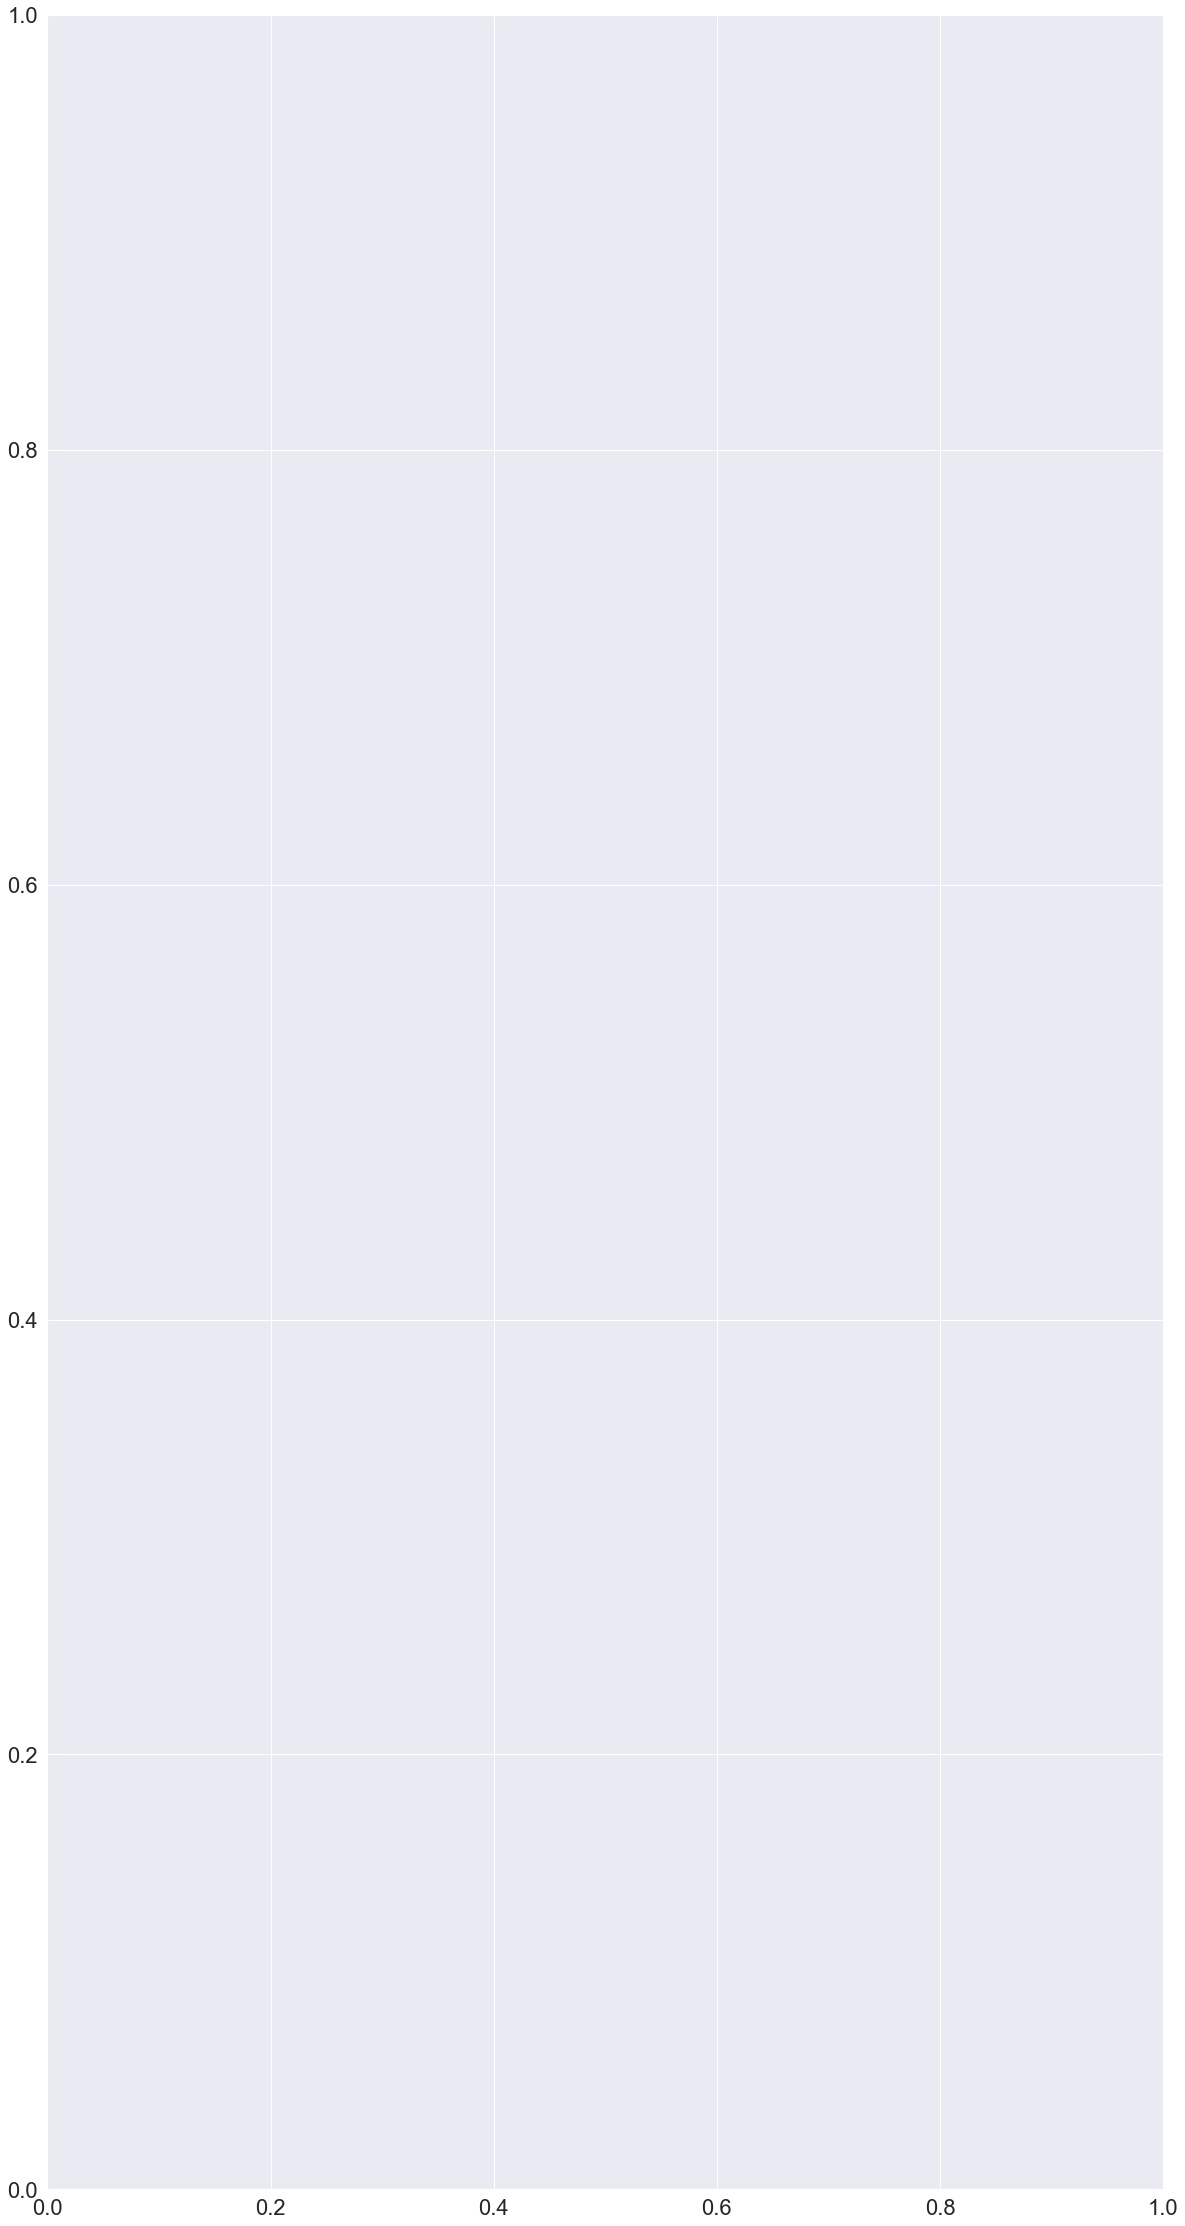

In [71]:
for channel in wp.channel.unique():
    profilePlot(channel_themes, channel)